In [8]:
import random
import matplotlib.pyplot as plt

In [9]:
#make the initial sample of lists of chromosomes
#here, a chromosome is a 0 or 1, with 0 = not included in knapsack
#and 1 = included in knapsack
#we will have a set number of chromosome groups, represented by the sample size
def getInitialChromosomes(sample_size = 100, pop_size = 50):
  return[[random.randint(0,1) for _ in range(pop_size)] for _ in range(sample_size)]

#make a knapsack from the chromosome lists
def pack(pop, chromosomes_list):
  knapsacks = []
  for chromosomes in chromosomes_list:
    knapsack = [pop[index] for index, chromosome in enumerate(chromosomes) if chromosome == 1]
    knapsacks.append(knapsack)
  return knapsacks


In [10]:
#compute the total weight of a collection of items
def weight(knapsack):
  return sum([item[0] for item in knapsack])

#compute the total value of a collection of items
def value(knapsack):
  return sum([item[1] for item in knapsack])

# assign a fitness score for each knapsack
# higher value = higher fitness score UNLESS the weight exceeds the maximum weight
def fitness_scores(knapsack, max_capacity):
  if weight(knapsack) <= max_capacity:
    return value(knapsack)
  elif weight(knapsack) > max_capacity:
    return 0.001 #options are 0 or a very small number


def selection_boundaries(fitness_scores):
  '''
  Makes a list of decision boundaries starting at 0, then adding fitness
  scores successively.  Larger fitness scores lead to bigger gaps between
  boundaries, indicating that these knapsacks are more likely to be selected
  as parents for the next generation.
  '''
  boundaries = [0]
  for index, score in enumerate(fitness_scores):
    boundaries.append(boundaries[index] + score)
  return boundaries

def generateFitterParents(decision_boundaries, knapsacks):
  '''
  We need a group of parents that are as fit as possible while preserving
  some random chance, diversity, etc. in the algorithm.  So, this uses
  the decision boundaries made before to probabilistically choose a sample
  of knapsacks.  More fit (i.e. higher value) knapsacks are more likely to be
  chosen.  Knapsacks with fitness scores of 0 cannot be chosen.
  '''
  fitter_knapsacks = []
  for current_boundary in decision_boundaries:
    total_fitness = current_boundary[-1]
    if total_fitness == 0:
      fitter_knapsacks.append(random.choice(knapsacks))
      continue
    random_number = random.uniform(0, current_boundary[-1])
    for index, boundary in enumerate(current_boundary[1:]):
      if random_number < boundary:
        fitter_knapsacks.append(knapsacks[index])
        break
  return fitter_knapsacks

def crossover(knapsack, fitter_knapsack, max_capacity, bias = 0.5):
  '''
  This algorithm will take each knapsack and pair it with its corresponding
  "fitter" knapsack.  We start by taking an unbiased 50% of the original knapsack
  and place those items in the child knapsack.
  Then, we work element-wise through the fitter knapsack, adding elements to the child
  only if they are not already in the child.
  There are cases where the child knapsack could be overweight.  In this case,
  we recursively call the crossover function to retry the algorithm with a harsher
  bias towards the first parent.
  '''
  num_to_sample = int(len(knapsack) * bias)
  selected_indices = random.sample(range(len(knapsack)), k = num_to_sample)
  child = []
  for index in selected_indices:
    child.append(knapsack[index])
  child_weight = weight(child)
  for item in fitter_knapsack:
    if item not in child and item[0] + child_weight <= max_capacity:
      child.append(item)
      child_weight += item[0]
  if weight(child) > max_capacity:
    bias = bias/2
    return crossover(knapsack, fitter_knapsack, max_capacity, bias)
  else:
    return child

def swapOne(child, pop):
  '''
  Helper function to be used with mutate. Swaps a random item from the population
  into a knapsack.
  '''

  if len(child) == 0:
    return child #no swap
  while True:
    swap_in = random.choice(pop)
    if swap_in not in child:
      break
  index_to_replace = random.randint(0, len(child)-1)
  child[index_to_replace] = swap_in
  return child

def mutate(children, pop, rate = 0.1):
  '''
  To preserve diversity in each generation, we want to occasionally mutate.
  This function will replace 0, 1, 2, or 3 items in the knapsack with a
  random item from the population that isn't already in the knapsack.
  To pick the number of items to be replaced, we use a geometric probability
  model:
  P(1 item is replaced) = 10%
  P(2 items are replaced) = 1%
  P(3 items are replaced) = 0.1%
  '''
  mutated_children = []
  for child in children:
    trigger = random.random()
    if trigger < rate**3:
      for _ in range(3):
        child = swapOne(child, pop)
    elif trigger < rate**2:
      for _ in range(2):
        child = swapOne(child, pop)
    elif trigger < rate:
      child = swapOne(child, pop)
    mutated_children.append(child)
  return mutated_children

def preserve_elites(knapsacks, fitness_scores, mutated_children, num_of_elites = 2):
  '''
  for each generation, we make sure that the two (or more) best knapsacks are
  preserved.
  '''
  pairs = zip(knapsacks, fitness_scores)
  elites = sorted(pairs, key = lambda x: x[1], reverse = True)[:num_of_elites]
  elite_knapsacks = [e[0] for e in elites]
  return elite_knapsacks + mutated_children[:-num_of_elites]

In [11]:
#unifying functions

def initializeKnapsackGA(pop, pop_size, max_capacity, sample_size):
  #Step 1:  Collect the sample of chromosomes
  chromosomes_list = getInitialChromosomes(sample_size, pop_size)

  #Step 2:  Use chromosomes to select sample of possible knapsacks
  knapsacks = pack(pop, chromosomes_list)
  return knapsacks

def knapsackGA(knapsacks, pop):
  #Step 3:  Iterate through knapsacks to compute fitness scores and decision boundaries
  decision_boundaries = []
  all_fitness_scores = []
  for knapsack in knapsacks:
    current_fitness_scores = fitness_scores(knapsack, max_capacity)
    all_fitness_scores.append(current_fitness_scores)
  decision_boundaries.append(selection_boundaries(all_fitness_scores))
  avg_fitness_score = sum(all_fitness_scores)/len(all_fitness_scores)
  #Step 4:  Select the fitter sample of knapsacks by iterating through the old sample
  fitter_knapsacks = generateFitterParents(decision_boundaries, knapsacks)

  #Step 5: Zip the parents together
  parents = zip(knapsacks, fitter_knapsacks)

  #Step 6: Breed children using crossover funtion
  children = []
  for parent1, parent2 in parents:
    children.append(crossover(parent1, parent2, max_capacity, bias = 0.5))

  #Step 7:  Mutation
  mutated_children = mutate(children, pop, rate = 0.1)

  #Step 8:  Preserve best knapsacks from previous generation
  mutated_children_preserved = preserve_elites(knapsacks, all_fitness_scores, mutated_children, num_of_elites = 2)

  #Step 8:  Return mutated children for next generation
  return mutated_children_preserved, avg_fitness_score

def fitnessScoreGrapher(average_fitness_scores):
  xvals = list(range(0, len(average_fitness_scores)))
  yvals = average_fitness_scores
  plt.plot(xvals, yvals, linestyle = '-', marker = 'o')
  plt.xlabel("Iteration")
  plt.ylabel("Average Knapsack Value (Fitness Score)")
  plt.title("Convergence Plot for Knapsack Value")
  plt.grid(True)
  plt.xlim(0, max(xvals)+1)
  plt.ylim(min(yvals)-100, max(yvals)+100)
  plt.show()

[[(25, 97), (21, 43), (19, 62), (8, 98), (32, 28), (33, 69), (33, 99), (26, 60), (44, 45), (35, 14), (46, 98), (9, 60), (44, 15), (10, 81)], [(42, 77), (40, 76), (20, 76), (45, 25), (8, 98), (12, 23), (33, 69), (33, 99), (37, 80), (9, 60), (7, 60), (10, 81)]]
Max Capacity of Knapsack: 440.0
Last Generation Weight:  385
Last Generation Value: 846.5
Best Value:  846.5
[302.60060000000004, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 846.5, 8

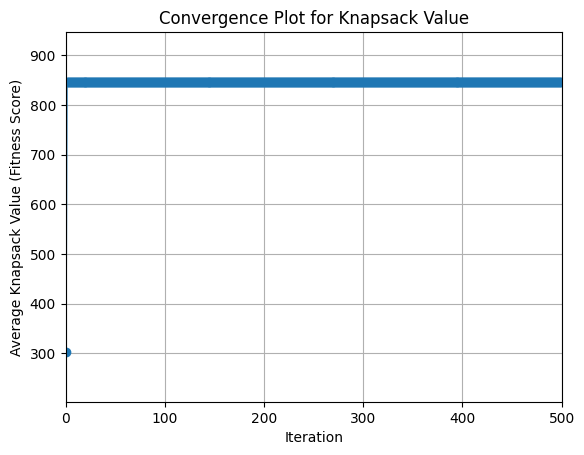

In [12]:
#main body

#define population of items
#each item is (weight, value)
pop_size = 30
pop = [(random.randint(5,50), random.randint(10,100)) for i in range(pop_size)]
pop_value_total = sum([a[1] for a in pop])
pop_weight_total = sum([b[0] for b in pop])
sample_size = 10
num_iterations = 500

#define max capacity of knapsack to be half the total weight of all items
max_capacity = pop_weight_total/2

#get first sample of knapsacks
gen = initializeKnapsackGA(pop, pop_size, max_capacity, sample_size)

average_fitness_scores = []

#iterate through generations of knapsacks
for _ in range(num_iterations):
  gen, score = knapsackGA(gen, pop)
  average_fitness_scores.append(score)

print(gen)
print(f"Max Capacity of Knapsack: {max_capacity}")
print(f"Last Generation Weight:  {weight(gen[0])}")
print(f"Last Generation Value: {average_fitness_scores[-1]}")
print(f"Best Value:  {max(average_fitness_scores)}")

print(average_fitness_scores)
fitnessScoreGrapher(average_fitness_scores)


